In [1]:
spark

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 6, Finished, Available)

In [2]:
## Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import PipelineModel


StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 7, Finished, Available)

In [3]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_clean_v2.parquet"
comments_sentiment_path = "/basketball_comments_sentiment.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
comments_sentiment = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_sentiment_path}")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 8, Finished, Available)

In [4]:
comments = comments.join(comments_sentiment.select("id", "col", "clean_text"), on="id", how='inner')

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 9, Finished, Available)

In [5]:
comments = comments.cache()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 10, Finished, Available)

In [6]:
comments = comments.filter(col("subreddit")=="CollegeBasketball")
comments = comments.withColumn("hour", hour("created_utc"))
comments = comments.withColumn("popular", when(comments["score"] > 8, 1).otherwise(0))
comments = comments.withColumn("comment_length", length("body"))
comments = comments.withColumnRenamed("col", "sentiment")
comments = comments.withColumn("supports_a_team", when(col("supported_team").isNull(), 0).otherwise(1))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 11, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 12, Finished, Available)

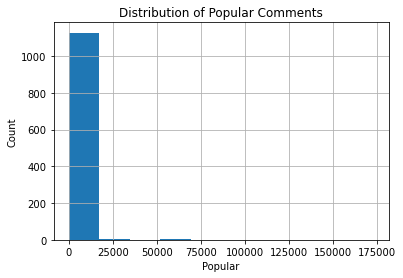

In [7]:
pandas_df = comments.select("score").toPandas()

counts = pandas_df['score'].value_counts()
counts.hist()

# Add labels and title
plt.title("Distribution of Popular Comments")
plt.xlabel('Popular')
plt.ylabel('Count')
# Show the plot
plt.show()

In [7]:
window_spec = Window.partitionBy("author")
comments = comments.withColumn("author_activity", F.count("author").over(window_spec))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 12, Finished, Available)

In [8]:
train_data, test_data = comments.randomSplit([0.8, 0.2], seed = 82)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
train_data = train_data.cache()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 13, Finished, Available)

Number of training records: 692712
Number of testing records : 172760


### Regression Version

In [9]:
stringIndexer_team = StringIndexer(inputCol='supports_a_team', outputCol="team_index", handleInvalid="skip") 
stringIndexer_month = StringIndexer(inputCol='month', outputCol="month_index", handleInvalid="skip") 
stringIndexer_sentiment = StringIndexer(inputCol='sentiment', outputCol="sentiment_index", handleInvalid="skip") 
onehot_sentiment = OneHotEncoder(inputCol="sentiment_index", outputCol="sentiment_vec")
onehot_month = OneHotEncoder(inputCol="month_index", outputCol="month_vec")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 14, Finished, Available)

In [10]:
feature_cols = ['comment_length', 'day', 'year', 'hour', 'author_activity', "month_vec", "sentiment_vec", "team_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 15, Finished, Available)

In [151]:
lr = LinearRegression(featuresCol="features", labelCol="score", maxIter=10, regParam=0.3, elasticNetParam=0.8)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 44, 158, Finished, Available)

In [13]:
rf = RandomForestRegressor(featuresCol="features", labelCol="score", maxDepth=15, numTrees=50)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 18, Finished, Available)

In [14]:
pipeline_model = Pipeline(stages = [
    stringIndexer_sentiment,
    stringIndexer_month,
    stringIndexer_team,
    onehot_month,
    onehot_sentiment,
    assembler,
    rf
])

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 19, Finished, Available)

In [15]:
model = pipeline_model.fit(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 20, Finished, Available)

In [17]:
model.write().overwrite().save("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v2")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 22, Finished, Available)

In [19]:
loaded_model = PipelineModel.load("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v2")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 24, Finished, Available)

In [21]:
predictions = loaded_model.transform(test_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 26, Finished, Available)

In [22]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))


StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 27, Finished, Available)

Root Mean Squared Error (RMSE) on test data = 36.21


In [23]:
predictions_df = predictions.sample(fraction = 0.07, seed = 92).select("prediction").toPandas()
true_labels_df = predictions.sample(fraction = 0.07, seed = 92).select("score").toPandas()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 28, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 46, 43, Finished, Available)

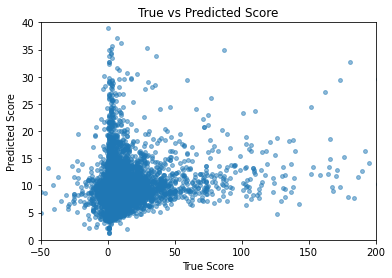

In [38]:
# Plot true values against predicted values
plt.scatter(true_labels_df, predictions_df, alpha=0.5, s = 15)
plt.title("True vs Predicted Score")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.ylim([0,40])
plt.xlim([-50,200])
#plt.xscale("log")
#plt.yscale("log")
plt.show()

In [159]:
model_lr = model.stages[-1]

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 44, 166, Finished, Available)

In [160]:
coefficients_df = pd.DataFrame(list(zip(feature_cols, model_lr.coefficients.toArray())),
                                columns=['Feature', 'Coefficient'])

print("Intercept: {:.2f}".format(model_lr.intercept))
print("Coefficients:")
coefficients_df.sort_values(by='Coefficient', ascending=False, inplace=True)
print(coefficients_df)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 44, 167, Finished, Available)

Intercept: 9.44
Coefficients:
           Feature  Coefficient
1              day     0.001184
0   comment_length     0.000000
2             year     0.000000
3             hour     0.000000
4  author_activity     0.000000
5        month_vec     0.000000
6    sentiment_vec    -0.622529
7       team_index    -1.014445


#### Version 2

In [11]:
rf_v2 = RandomForestRegressor(featuresCol="features", labelCol="score", maxDepth=15, numTrees=500)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 16, Finished, Available)

In [12]:
pipeline_model_v2 = Pipeline(stages = [
    stringIndexer_sentiment,
    stringIndexer_month,
    stringIndexer_team,
    onehot_month,
    onehot_sentiment,
    assembler,
    rf_v2
])

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 17, Finished, Available)

In [13]:
model_v2 = pipeline_model_v2.fit(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 18, Finished, Available)

In [14]:
model_v2.write().overwrite().save("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v3")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 19, Submitted, Running)

In [15]:
loaded_model_v2 = PipelineModel.load("Users/vankempenklaas/fall-2023-reddit-project-team-26/code/ml/model_files/popularity_model_v3")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 20, Finished, Available)

In [17]:
predictions = loaded_model_v2.transform(test_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 22, Finished, Available)

In [18]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 23, Finished, Available)

Root Mean Squared Error (RMSE) on test data = 36.05


In [19]:
predictions_df = predictions.sample(fraction = 0.07, seed = 92).select("prediction").toPandas()
true_labels_df = predictions.sample(fraction = 0.07, seed = 92).select("score").toPandas()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 47, 24, Finished, Available)

In [ ]:
# Plot true values against predicted values
plt.scatter(true_labels_df, predictions_df, alpha=0.5, s = 15)
plt.title("True vs Predicted Score")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.ylim([0,40])
plt.xlim([-50,200])
#plt.xscale("log")
#plt.yscale("log")
plt.show()